<h1>Introduction, background and aims</h1>

<p>The recent explosion in crypto currencies as 'investment assets' easily offered to the public has fueled significant volatility as witnessed in price movements of over 30 % daily. Naturally, many attempts have been made to try and give some re-assurance to investors by various 'oracles' in the crypto currency space. This mini-research project will try to explore the capabilities of two crypto pricing prediction tools with the aim to understand whether such tools can be used as one-of-many indicators to predict price movements of crypto currencies such as bitcoin (BTC). 
          The two prediction tools that will be explored in this project are: </p>
          <ul>
	<li>A crypto fear index provided by alternative.me; and </li>
	<li>A rudimentary twitter sentiment model 'created' by the author, using the NLTK vader sentiment analysis prediction model, slightly modified to suit the project's needs.</li></ul>

          

<h1> Dataset acquisition, cleaning and analysis</h1>
<p>The datasets for this project will be acquired through web APIs. The APIs provided by the crypto fear index tool and twitter API. Lastly, a dataset that provides pricing data for the given period will be necessary to compare against the results, which will be provided by the crypto currency website's API, CoinGecko.</p> 
<p>The criteria used in selecting these datasets were accuracy availability, and representation. With regard to accuracy, the crypto fear index is an infamous tool among the crypto space for its predictions, thus it provides a good background against which the rudimentary twitter sentiment analysis tool can be checked.
The availability of a huge dataset from which to draw upon for sentiment analysis is provided by twitter’s database, since it is the go-to space for most crypto enthusiasts voicing their opinions. 
Lastly, CoinGecko provides the market price data required to gauge the performance of both tools. 
 </p> 


<h3>Acquisition</h3>
<p> 
The first dataset, was acquired through the twitter API. This dataset will provide the sample data to be analyzed by the vader sentiment sentiment tool. The dataset includes around 8000 entries of tweet texts and spans 6 days. The tweet texts were randomly chosen by the API but all include the hashtag btc. In addition, the sample frequency chosen was 60 tweets per hour over a 6 day span (which is what Twitter allows for non-enterprise accounts, other restrictions include parameters such as choosing tweet location, verified users etc.) and the language of tweets was narrowed down to include only English to avoid skewing the data.
</p>
<p>The second dataset was acquired from the CoinGecko API. This dataset includes price movements of the selected crypto currency vs USD over the same period of time as the twitter data. 

The third and last dataset includes a 'fear index' values of which are calculated by the website (https://alternative.me/crypto/fear-and-greed-index/#api) through a combination of techniques that gauge various market indicators (e.g. as social media sentiment, google trends, market dominance, market volatility and momentum) in a daily frequency.
</p>
<p> Acquiring all datasets took approximately 40 minutes, mostly because of the many twitter API calls, all datasets were saved in their original JSON formats for offline and later use.</p>



<h3>Limitations of data</h3>
<h4>Twitter texts</h4>
<p>The twitter text was randomly selected by twitter's API for the given query. The query used here was '#btc',however it is important to note that this could be improved with more hashtags etc. but was out of the scope of this project. Moreover, access to specific filters that can narrow down tweets by user and or geographic location was not available. In addition, the API limits the historical data available for non-enterprise accounts, so in this case access was granted only to the most recent tweets, recent being defined as the previous 7 days. Lastly, when it comes to harnessing the power of the crowds, the more data is always the merrier. This sample has a meak 8640 texts so it is safe to assume that it results may not be that wise in the end.</p>
<h4>Fear index</h4>
<p> Because the fear index uses social media as one of its variables, there may be some overlap between the results of the fear index and those of the sentiment analysis performed in this project. However, as stated by its authors social media form only 15% of its data sources, so the overlap may be ignored for the purposes of this project. Another limitation is its granularity as it is updated once per day, there are no other frequencies available. However, one can imagine that market prices can be upscaled to a daily mean and then compared against.</p>

<h3>Ethical considerations</h3>

<p> The Twitter API imposes its own restrictions to data drawing by way of account levels. In addition, its terms and conditions state that data drawn can be used for academic research and or use. Consent by its users is given when they use the platform, so Twitter can use their data, and this project can use its data. Data privacy at its finest.</p>
<p> The FearIndex imposes its own restrictions to data drawing and limits the number of possible requests to 60 per 10 minutes. It also offers its data free of charge for any use. CoinGecko has similar restrictions imposed with a rate of 50 API calls per minute. Its data are also free of charge and can be used freely.</p>
<h4> Reuse and ownership of results</h4>
<p> Any person desiring to use the source data (that is, the twitter texts) would need to abide by the terms and conditions of twitter at the time, and independently make an account in the platform. Data derived from the source from the source would fall under the same restrictions as the source text.
Analysis and conclusions are my own and can reused by anyone. </p>
<p>Finally, the results of this project or any of the contents of the datasets do not represent investment advice. </p>


<i>Load necessary modules here.</i> 

In [1]:
# System modules

from pathlib import Path
import json 
import os 
import string
import re
import csv
from datetime import *

# Data cleaning and analysis

import numpy as np
import pandas as pd
import nltk.corpus
from nltk.tokenize import *
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from enchant.checker import SpellChecker
import matplotlib.pyplot as plt
import matplotlib 

# Data acquisition  

from aiohttp import ClientSession
from pycoingecko import CoinGeckoAPI
import requests


<h4>A number of modules used in acquiring the data and cleaning it.</h4>

In [2]:

""" 
A module to save API responses in JSON format. 
Takes in a response json-style string, dumps it to the file specified. 
Can be called multiple times on the same file.
"""
def saveResponse(response,filename,format):
    p = Path('/home/solo/Desktop/PwD/PwD/Darth_Crypter')

    with open(p / f'{filename}.{format}', 'a') as file:
          # print(filename,format)
          json.dump(response,file)
          file.write('\r\n')
          

In [3]:
"""
A small module to make a request url for an API call.
Takes in a string endpoint, a dict with headers, and the main query call if available.
Returns a complete request URL if possible.
"""
# How a valid twitter API call should like look, in case the makeURL function doesnt work
# url = f'https://api.twitter.com/2/tweets/search/recent?query={query}&start_time={headers["start_time"]}&end_time={headers["end_time"]}&max_results={headers["max_results"]}&tweet.fields={headers["tweet.fields"]}'
def makeUrl(endpoint, headers, _query=''):
          headerKeys = list(headers.keys())
          headerValues = list(headers.values())
          query = _query 
          
          lambda query:  query if query != "" else '?'
          
          if query == '?':
                    url = f'{endpoint}'+f'{query}'
          else:
                    url = f'{endpoint}'+f'?query={query}'

          for i in range(len(headerKeys)):
                    if(i == 0 and query == '?'):
                              url = url+f'{headerKeys[i]}={headerValues[i]}'

                    else:
                              url = url+f'&{headerKeys[i]}={headerValues[i]}'

         
          return url


In [4]:
"""
A small response fetcher module using aiohttp to make async multiple calls.
Takes in a url, headers. Returns a json string. 
Uses only http.get
"""
async def fetch(url, headers=''):

    async with ClientSession(headers=headers) as session, session.get(url) as res:

        ret = await res.json()
        return ret


In [5]:
"""
An averaging function made to work with a list of frequencies and a list of values. 
Lists must be equal. Returns a dict with both avgFreq and avgValues 
"""
def getAverage(list1, list2, slice1, slice2, dictKey1, dictKey2, convertToDateObject=False):
          sum = 0
          count = 0
          avgScores = []
          avgTimeframe = []
         
          prev = None
          for i in range(len(list1)):

                    try:
                              # get the next timestamp and convert or not

                              if convertToDateObject:
                                        nxt = datetime.fromisoformat(list1[i][slice1:slice2])
                                        
                              else:
                                        nxt = list1[i][slice1:slice2]
                              
                              
                              # add the next timestamp's score to the sum
                              sum += float(list2[i])

                              # if the next timestamp is the same as the previous one
                              # then increase the counter

                              # if it is not, then add the sum and reset counters but first remove the previously wrongly added score
                              if nxt != prev and prev != None:
                              # print(scores[i])
                                        sum -= float(list2[i])
                                        
                                        avgScores.append(sum/count)
                                        avgTimeframe.append(prev)
                                        sum = float(list2[i])
                                        count = 0

                              prev = nxt
                              if nxt == prev:
                                        count += 1
                              if i == len(list1)-1:
                                        avgTimeframe.append(nxt)
                                        avgScores.append(sum/count)
                    except IndexError:
                              break;
          return {f'{dictKey1}': avgTimeframe,  f'{dictKey2}': avgScores}


In [6]:
# example twitter query
# https://api.twitter.com/2/tweets/search/recent?query=btc&start_time=2022-01-01T00:00:00Z&end_time=2022-01-04T00:00:47Z&max_results=100&tweet.fields=created_at&place.fields=country_code&user.fields=verified,created_at

endpoint = f'https://api.twitter.com/2/tweets/search/recent'
payload = {}
start = datetime(2021, 12, 31,00, 00, 00)
end = datetime(2022, 1, 5, 6, 00, 00)

"""
Gets twitter responses by using the fetch module, then saves them in a JSON file by using the saveSesponse module.
"""     
async def getResponses(start, end, query="", bearer_token=""):

          secondsInHour = 3600
          minutesInHour = 60 
          
          # get the timedelta between start and end in hours
          timeDiff = end-start
          totalHours = int(timeDiff.total_seconds() / secondsInHour)
          
          tweetInterval = timedelta(minutes=10)  
      
          # new end to start request iteration
          end = start+tweetInterval

          payload = {}
          
          headers = {
                    'Authorization': f"Bearer {bearer_token}",
                    'start_time': start.isoformat()+'Z',  
                    'end_time': end.isoformat()+'Z',  
                    'max_results': '10',
                    'tweet.fields': 'lang,created_at',
                    'next_token' :''
          }
          query = query
          # make the appropriate url and insert headers 
          url = makeUrl(endpoint,headers,query)
          
          for i in range(totalHours): #for each hour
                    
                    for j in range(minutesInHour/tweetInterval):        #make the appropriate requests                                                     
                    
                              try:
                                        start = end
                                        end +=tweetInterval
                              
                                        print("end: ",end,"start: ", start)
                                        
                                        res = await fetch(url)

                                        saveResponse(res,'test2',"json")
                                        
                                        headers['end_time'] = end.isoformat()+'Z'
                                        headers['start_time'] = start.isoformat()+'Z'
                                        # url = f'https://api.twitter.com/2/tweets/search/recent?query={query}&start_time={headers["start_time"]}&end_time={headers["end_time"]}&max_results={headers["max_results"]}&tweet.fields={headers["tweet.fields"]}'
                                        url= makeUrl(endpoint,headers,query)
                                        
                                        # Gets the next page of results, if available.
                                        if(res['meta']['next_token'] != None ):
                                                  headers['next_token'] = res['meta']['next_token']
                                        else:
                                                  break
                              
                              except Exception as err:
                                        print(f"Error: {err}")
          

<h3>Cleaning the data</h3>
<p>Both price market and fear index datasets are cleaned per se, however they required particular reformatting in order to display their findings properly for this project's needs. These datasets were acquired with different time formats and so needed conversion to appropriate types to maintain overall uniformity of the exploration. In the case of market prices, conversion from UNIX epoch (which included an extra four digits that needed to be divided out) to python datetime objects and in the case of the fear index, dates were provided in the DD-MM-YYYY format. </p>

<p>The twitter dataset required most of the cleaning as it was received in many JSONs that included text, probable language used and creation dates. Each JSON had 10 tweets and had to be checked for each tweet's language and creation date. Subsequently, the raw tweet text was extracted and was passed through 5 normalization steps. These steps were:</p> 
<ul>
<li>formatting the text to lower case, removing any special characters such as emojis,links,etc. </li>
<li> removing non-english or incorrectly spelled words 
</li>
<li>ignoring stop words
 </li>
<li>tokenized and lemmatized
 </li>
 <li>mean hourly and daily sentiment scores</li>
</ul>
<p>It is important to note that lower case vs upper case affected the results of the sentiment analysis module since it is case sensistive, thus in the end this step was removed from the pipeline. Moreover, the lemmatizer indicated insignificant effects on the outcome so it was also removed. Finally, a mean of all 10 tweets according to their time of tweeting was produced, and added to a file. </p>


Running the twitter API requests here, saving responses to a json.

In [7]:
# with open('./twittertoken.txt', 'r') as bearer_token:
          # await getResponses(start,end,query='btc',bearer_token)
# endpoint  = "https://api.twitter.com/2/tweets/search/recent"
# url = makeUrl(endpoint,headers,'btc')

Running the market price API calls with CoinGecko's own client here and loading to dataframes.

In [8]:
cg = CoinGeckoAPI()

startPOSIX = (start - datetime(1970, 1, 1)) / timedelta(seconds=1)
endPOSIX = (end+timedelta(days=0.5) - datetime(1970, 1, 1)) / timedelta(seconds=1)
marketPricesAndTimes = cg.get_coin_market_chart_range_by_id(id='bitcoin',vs_currency='usd',from_timestamp=startPOSIX,to_timestamp=endPOSIX)

marketPricefn = 'marketPrices'

# saveResponse(marketPricesAndTimes,"marketPrices",'json')

# separate data and format POSIX frequencies to datetime objects
 
with open('./marketPrices.json','r') as marketPriceData:
          marketPriceJSON = json.load(marketPriceData)
          marketPriceTimes = []
          marketPrices = []
          marketPriceDays=[]
          for row in marketPriceJSON['prices']:
                    dt = datetime.fromtimestamp(int(row[0])/1000)
                    marketPriceTimes.append(dt)
                    marketPriceDays.append(dt.isoformat())
                    marketPrices.append(float(row[1]))
      
marketPriceDailyAverages = getAverage(marketPriceDays, marketPrices, 0, 10, 'days', 'avg', True)
marketPriceDays = marketPriceDailyAverages['days']
marketPriceDailyPrices = marketPriceDailyAverages['avg']

# load the lists in a dataframe
marketPriceandTimesHourly = pd.DataFrame(marketPrices,index=marketPriceTimes,columns=['price'])
marketPriceandTimesDaily = pd.DataFrame(marketPriceDailyPrices, index=pd.to_datetime(pd.Series(marketPriceDays)), columns=['avg'])

marketPriceandTimesHourly.head()

,price
2021-12-31 02:04:53.614,47191.868390
2021-12-31 03:06:09.737,47105.561774
2021-12-31 04:04:03.205,47217.563320
2021-12-31 05:04:01.056,47092.892035
2021-12-31 06:01:50.969,47335.612908


In [9]:
marketPriceandTimesHourly.describe()

,price
count,138.000000
mean,46969.230227
std,556.456491
min,45794.698823
25%,46519.545449
50%,47038.674496
75%,47339.243786
max,48634.694887


In [10]:
marketPriceandTimesDaily.describe()

,avg
count,6.000000
mean,46960.690267
std,421.182317
min,46425.439714
25%,46617.460554
50%,47034.614940
75%,47270.500345
max,47441.934099


Running the fear index API calls and loading to dataframes.

In [11]:
# endpoint = 'https://api.alternative.me/fng/'

# set headers to number of days calculated from tweeter
# headers = {'limit':'10','format':'json','date_format':'world'}

# set filename
# marketFearDatafn = 'marketFearData'

# Get the data from the API
# marketFearIndex = requests.request("GET", url,data=payload)

# Save response to a json file.
# saveResponse(marketFearIndex,marketFearDatafn,'json')

# load the json file 
with open('marketFear.json', 'r') as marketFearfile:
    marketFearJson = json.load(marketFearfile)
   



marketFearValues = [] # to hold marketFear values
marketFearTimes = []  # to hold marketFear frequencies

# reformatting the dates in the dataset
for line in marketFearJson['data']:
          
          day = line['timestamp'][0:2]
          month = line['timestamp'][3:5]
          year = line['timestamp'][6:10]
          makeDate = date(int(year), int(month), int(day))
          # retain only dates that correspond to the twitter dataset
          if makeDate < start.date() or makeDate > end.date():
                    
                    continue
                    
          else: 
                    marketFearValues.append(int(line['value']))
                    marketFearTimes.append(makeDate)
                    



# reverse the lists order for proper plotting later

marketFearTimes.reverse()
marketFearValues.reverse()

# load times in pd series to demonstrate usage !
marketFearTimes = pd.to_datetime(pd.Series(marketFearTimes))

# load everything in a dataframe 
marketFear = pd.DataFrame(marketFearValues, index=marketFearTimes, columns=['value'])

In [12]:
marketFear.describe()

,value
count,6.000000
mean,25.666667
std,3.444803
min,21.000000
25%,23.250000
50%,26.000000
75%,28.750000
max,29.000000


Normalize and clean twitter data.

In [13]:
# Initialize all required modules used in cleaning the twitter data 

twTokenizer = TweetTokenizer(strip_handles=True,reduce_len=True) 

# for checking non-english or slang words in the text 
checker = SpellChecker('en_US')

# simplifying the text fed to vader 
stop = nltk.corpus.stopwords.words('english')

#to demonstrate lemmatizing 
lemmatizer= WordNetLemmatizer()

# the vader sentiment analysis module
analyzer = SentimentIntensityAnalyzer()

#Adding specific investment slang words to the booster dictionary used by vader sentiment analysis tool.
analyzer.constants.BOOSTER_DICT['bullish'] = analyzer.constants.B_INCR
analyzer.constants.BOOSTER_DICT['moon'] = analyzer.constants.B_INCR
analyzer.constants.BOOSTER_DICT['bearish'] = analyzer.constants.B_DECR


#  normalization of twitter text and Sentiment analysis here
# with open('twitterdata.json', 'r') as tweetObjects:
          
#           with open('sentimentResults.txt','a') as scoresFile:
                    
#                     scoresFile.write('time,score\r')
#                     for line in tweetObjects:
#                               """ write each timestamp in the scores csv """
                              
#                               tweetObject = json.loads(line)
#                               scoresFile.write(f"{tweetObject['data'][0]['created_at']},")
#                               timestamp = tweetObject['data'][0]['created_at']
#                               timestampScore = 0
#                               print(timestamp)
                              
#                               # normalize tweet texts
#                               validTweets = 0
#                               for i in range(len(tweetObject['data'])):
                                        
#                                         # ignore non english tagged tweets
                                      
#                                         if(tweetObject['data'][i]['lang']=='en'):
#                                                   validTweets+=1
#                                                   #print(text)

#                                                   text = tweetObject['data'][i]['text']
                                                  
#                                                   # print(text)
                                                  
#                                         # make all words in the tweet lower case - however vader sentiment analysis is case sensitive so results may vary
#                                                   # text = text.lower()
                                                  
#                                         # remove special characters, links etc
#                                                   # print(text)

#                                                   text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
                                        
#                                         # remove non-english words 
#                                                   #print(text)

#                                                   checker.set_text(text)
#                                                   for err in checker:
#                                                             err.replace('')
#                                                   text = checker.get_text()
#                                                   #print(text)

#                                         # stemmer here - doesnt make much difference           
                                                  
#                                                   # text = twTokenizer.tokenize(text)
#                                                   # text = [lemmatizer.lemmatize(word) for word in text]
                                                 
#                                                   # newText=''
#                                                   # for word in text:
#                                                   #           newText += word + ' '

#                                                   # text = newText
                                                  
#                                                   # print(text)

#                                         # ignore stop words
#                                                   text = " ".join([word for word in text.split() if word not in (stop)])
                                                  
                                                 
#                                                   # # print(tokens)
                                                  
                                               
#                                                   # print(text)
#                                                   scores = analyzer.polarity_scores(text)
                                                  
#                                                   # print(scores['compound'])
#                                                   timestampScore += scores['compound']
                                              
#                                                   # print(scores['compound'])

#                     # writing out the results
#                               scoresFile.write(f"{timestampScore/validTweets}\r\n")


Unpack the sentiment analysis results to 2 lists of mean frequencies and mean scores (hourly mean, daily mean), then load them to dataframes.

In [14]:
with open('./sentimentResults.txt', 'r', newline='') as scoresFile:
          scoresCSV = csv.DictReader(scoresFile,delimiter=',')
          dTimes =[] # to hold frequencies as date objects
          times = [] # to hold frequencies as strings 
          scores = []
          for row in scoresCSV:
                    times.append(row['time'])
                    scores.append(row['score'])
                    dTimes.append(datetime.fromisoformat(row['time'][0:-5]))

# Get the daily/hourly sentiment analysis means
sentimentDailyAverage = getAverage(times, scores, 0, 10, 'days', 'avg')
sentimentHourlyAverage = getAverage(times, scores, 0, 13, 'hours', 'avg', True)

# Load the dataframes with a corresponding pandas time series to retain uniformity
sentimentDaily = pd.DataFrame(sentimentDailyAverage['avg'], index=pd.to_datetime(
    pd.Series(sentimentDailyAverage['days'])), columns=['avg'])
sentimentHourly = pd.DataFrame(sentimentHourlyAverage['avg'],index=sentimentHourlyAverage['hours'] ,columns=['avg'])
                

In [15]:
sentimentDaily.describe()

,avg
count,6.000000
mean,0.247572
std,0.016444
min,0.226018
25%,0.237886
50%,0.245018
75%,0.259796
max,0.269146


In [16]:
sentimentHourly.describe()

,avg
count,126.000000
mean,0.244445
std,0.073392
min,0.038130
25%,0.193406
50%,0.240775
75%,0.286275
max,0.427469


<h3>Analysis</h3>

<p>In order to provide a better overview of the sentiment results, an hourly as well as a daily statistical mean of the results were calculated. 
</p><p>From the four plots, two findings can be noted. First, there was indeed some correlation between market prices and twitter sentiment analysis results. Secondly, the market fear index was also a good indicator of price swings. Of course, such predictions cannot be safely drawn by such a limited dataset, at least for the vader sentiment analysis, however it is still an interesting outcome, since it hints at a possible behavioral marker affecting crypto currency prices. Moreover, it appeared that the vader sentiment analysis correlated well with the more sophisticated market fear index in predicting price swings. The sentiment hourly mean was closer to the market price swings since it had the same time frequency with the market price dataset.</p>




<i>Display all dataframes to draw results and conclusions!</i>
<p>Positive results per vader module are above 0.0 which may suggest an upwards trend and vice versa for scores below 0.0. </p>
<p>
On the other hand, The market fear index merely shows the overal sentiment of the market. Low scores indicate a buy signal, higher scores a sell signal. </p>

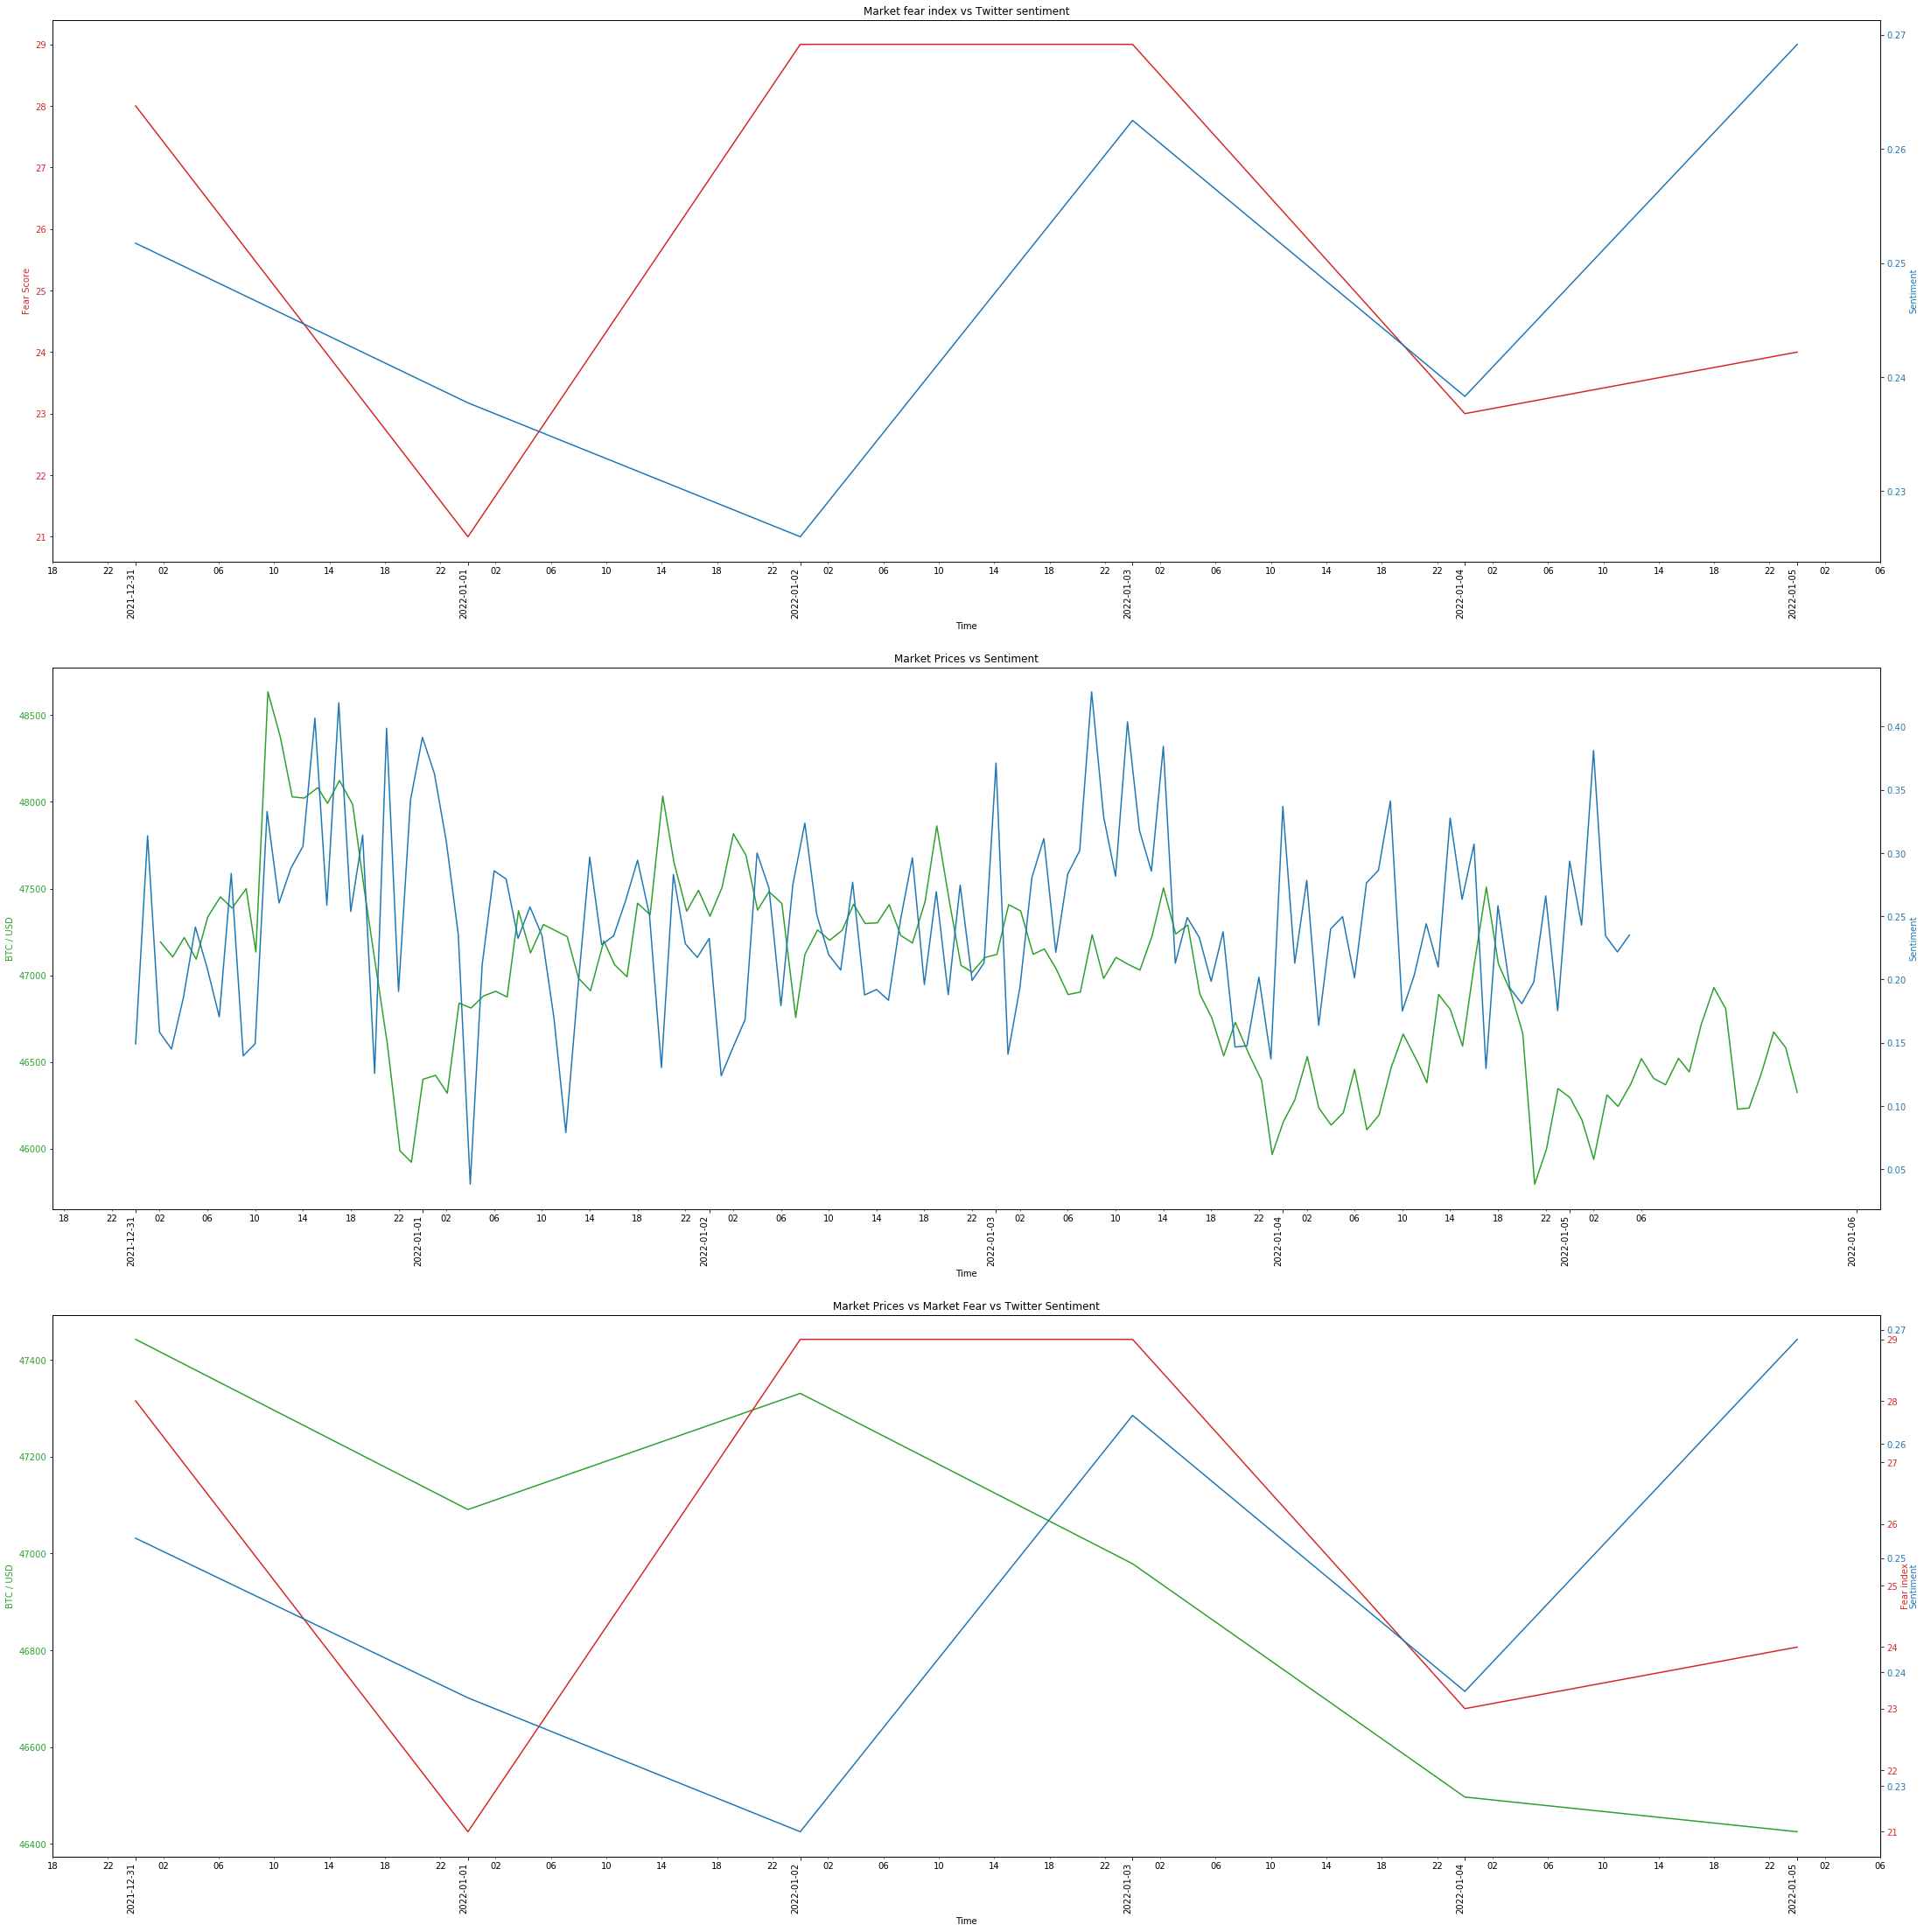

In [17]:
fig, (marketFearAx, marketPriceHourlyAx,marketPriceDailyAx) = plt.subplots(3, figsize=(30, 30))
hours = matplotlib.dates.HourLocator(interval=4)
hoursFrmt = matplotlib.dates.DateFormatter('%H')

fig.tight_layout(pad=2,w_pad=10,h_pad=10)

# Market fear v Twitter sentiment
pricesColor = 'tab:green'
fearColor = 'tab:red'
sentColor = 'tab:blue'

marketFearAx.plot(marketFear, color=fearColor)
marketFearAx.tick_params(axis='y', labelcolor=fearColor)
marketFearAx.set_title('Market fear index vs Twitter sentiment')
marketFearAx.set_xlabel('Time')
marketFearAx.set_ylabel('Fear Score', color=fearColor)
marketFearAx.xaxis.set_minor_locator(hours)
marketFearAx.xaxis.set_minor_formatter(hoursFrmt)
for label in marketFearAx.get_xticklabels(which='major'):
          label.set(rotation=90, horizontalalignment='right')
marketSentDailyAx = marketFearAx.twinx()
marketSentDailyAx.set_ylabel('Sentiment', color=sentColor)
marketSentDailyAx.plot(sentimentDaily['avg'], color=sentColor)
marketSentDailyAx.tick_params(axis='y', labelcolor=sentColor)


# market price vs twitter sentiment
marketPriceHourlyAx.plot(marketPriceandTimesHourly['price'], color=pricesColor)
marketPriceHourlyAx.set_title('Market Prices vs Sentiment')
marketPriceHourlyAx.set_xlabel('Time')
marketPriceHourlyAx.set_ylabel('BTC / USD', color=pricesColor)
marketPriceHourlyAx.tick_params(axis='y', labelcolor=pricesColor)
marketPriceHourlyAx.xaxis.set_minor_formatter(hoursFrmt)
marketPriceHourlyAx.xaxis.set_minor_locator(hours)
for label in marketPriceHourlyAx.get_xticklabels(which='major'):
    label.set(rotation=90, horizontalalignment='right')
marketSentHourlyAx = marketPriceHourlyAx.twinx()
marketSentHourlyAx.set_ylabel('Sentiment',color=sentColor)
marketSentHourlyAx.plot(sentimentHourly['avg'], color=sentColor)
marketSentHourlyAx.tick_params(axis='y', labelcolor=sentColor)

# market fear v market price
marketPriceDailyAx.plot(marketPriceandTimesDaily['avg'],color=pricesColor)
marketPriceDailyAx.set_title('Market Prices vs Market Fear vs Twitter Sentiment')
marketPriceDailyAx.set_xlabel('Time')
marketPriceDailyAx.set_ylabel('BTC / USD', color=pricesColor)
marketPriceDailyAx.xaxis.set_minor_formatter(hoursFrmt)
marketPriceDailyAx.xaxis.set_minor_locator(hours)
for label in marketPriceDailyAx.get_xticklabels(which='major'):
    label.set(rotation=90, horizontalalignment='right')
marketPriceDailyAx.tick_params(axis='y', labelcolor=pricesColor)

fearVDaily= marketPriceDailyAx.twinx()
fearVDaily.plot(marketFear, color=fearColor)
fearVDaily.set_ylabel('Fear index', color=fearColor)
fearVDaily.tick_params(axis='y', labelcolor=fearColor)

sentVDaily = marketPriceDailyAx.twinx()
sentVDaily.plot(sentimentDaily['avg'],color=sentColor)
sentVDaily.set_ylabel('Sentiment', color=sentColor)
sentVDaily.tick_params(axis='y', labelcolor=sentColor)


<h3>Summary</h3>

<p> The visual representation of the datasets provides a rough estimate of correlation between market prices and fear value / twitter sentiment with some lagging between sentiment and coresponding prices can be noted in some cases, with the market fear correlating in 3 out of 6 days with the twitter sentiment results. The only finding this project can attest to is that more data is required to arrive at a better result, at least one where money can be invested on ! However, the visualizations above help estimate that at certain times buy and sell signals may be estimated on a rough basis. 

For example, on 1.1.2022 the market fear index and twitter sentiment note a significant decline. If a sampling investment of $1000 was made on that day at the average pricepoint of $47,200 and the same investment be sold on the next datapoint of 2.1.2022, a small profit could be gained selling at the average pricepoint of $47,300. The respective market fear and sentiment datapoints for these days respectively indicate a sell and a buy signal. On the next day of 3.1.2022, both signals convert to sell, a wise choice if the market price is taken into account for the next days.  

While by no means conclusive, it appears that the baseline provided as reference by the market fear index, retains some correlation with market prices, on the other hand the twitter sentiment analysis perhaps requires more data or better analysis. However, safe conclusions cannot be drawn for either.
</p>

<p> Data involved in the above analysis: </p>

Market Fear dataframe

This dataframe holds the time series of interest and corresponding daily market fear values.
Its use was to provide a secondary measure against which twitter sentiment results could be cross checked.

In [18]:
marketFear.columns

Index(['value'], dtype='object')

Market prices dataframe

Holds the time series of interest and hourly/daily price points. 

This dataframe was only formatted to retain period uniformity. 
Its use was to provide the background against which sentiment results and market fear values were checked for correlation between prices and their values.

In [19]:
marketPriceandTimesHourly.columns

Index(['price'], dtype='object')

In [20]:
marketPriceandTimesDaily.columns

Index(['avg'], dtype='object')

Twitter sentiment results dataframes

This dataset was received in a JSON format. 
The raw text was extracted, normalized for slang/spelling, special characters and stop words and
subsequently fed to the vader sentiment analysis module for scoring. An hourly and a daily mean were then calculated.

In [21]:
sentimentDaily.columns

Index(['avg'], dtype='object')

In [22]:
sentimentHourly.columns

Index(['avg'], dtype='object')

References:
  
"Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014."

<h3>Resources used:</h3>

1. NLTK
2. PyEnchant
3. aiohttp
4. Pandas
5. Requests
6. Matplotlib
7. PyCoinGecko